1. Mount Google Drive

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Import Necessary Libraries

In [52]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

3. Define the Custom Dataset

In [53]:
class UIEB_Dataset(Dataset):
    def __init__(self, raw_dir, reference_dir, transform=None):
        self.raw_dir = raw_dir
        self.reference_dir = reference_dir
        self.image_names = sorted(os.listdir(raw_dir))  # Ensure consistent ordering
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        raw_image_path = os.path.join(self.raw_dir, self.image_names[idx])
        reference_image_path = os.path.join(self.reference_dir, self.image_names[idx])

        raw_image = Image.open(raw_image_path).convert('RGB')
        reference_image = Image.open(reference_image_path).convert('RGB')

        if self.transform:
            raw_image = self.transform(raw_image)
            reference_image = self.transform(reference_image)

        return raw_image, reference_image


4. Define Data Transformations and Create DataLoader

In [54]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Directory paths
raw_dir = '/content/drive/MyDrive/DIP_Project/raw-890/'
reference_dir = '/content/drive/MyDrive/DIP_Project/reference-890/'

# Create the dataset and dataloader
dataset = UIEB_Dataset(raw_dir, reference_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)


5. Define the ResnetBlock, ResnetGenerator, and NLayerDiscriminator

In [55]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, norm_layer=nn.BatchNorm2d, padding_type='reflect', use_dropout=False, use_bias=True):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, norm_layer, padding_type, use_dropout, use_bias)

    def build_conv_block(self, dim, norm_layer, padding_type, use_dropout, use_bias):
        conv_block = []

        # Padding
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            conv_block += [nn.ZeroPad2d(1)]
        else:
            raise NotImplementedError(f'Padding type {padding_type} not implemented')

        # Conv Layer
        conv_block += [
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
            norm_layer(dim),
            nn.ReLU(True)
        ]

        # Dropout
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        # Padding
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            conv_block += [nn.ZeroPad2d(1)]
        else:
            raise NotImplementedError(f'Padding type {padding_type} not implemented')

        # Conv Layer
        conv_block += [
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
            norm_layer(dim)
        ]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


In [56]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator"""

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, padding_type='reflect', use_dropout=False, n_blocks=9):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
            norm_layer(ngf),
            nn.ReLU(True)
        ]

        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)
            ]

        # ResNet blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer, padding_type=padding_type, use_dropout=use_dropout)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                   kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [57]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        use_bias = norm_layer != nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)


6. Initialize Models, Loss Functions, and Optimizers

In [58]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize models
netG = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, padding_type='reflect', use_dropout=True, n_blocks=9).to(device)
netD = NLayerDiscriminator(input_nc=3, ndf=64, n_layers=3, norm_layer=nn.InstanceNorm2d).to(device)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_L1 = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))


Using device: cuda


7. Define Checkpointing Mechanism

In [59]:
# Directory to save checkpoints
checkpoint_dir = '/content/drive/MyDrive/DIP_Project/checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save checkpoint
def save_checkpoint(state, filename):
    torch.save(state, filename)

# Function to load the latest checkpoint
def load_checkpoint(modelG, modelD, optimizer_G, optimizer_D, checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if not checkpoints:
        print("No checkpoints found, starting from scratch.")
        return 0  # Start epoch
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[1].split('.pth')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    print(f"Loading checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    modelG.load_state_dict(checkpoint['modelG_state_dict'])
    modelD.load_state_dict(checkpoint['modelD_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")
    return start_epoch


8. Load Checkpoint if Available

In [60]:
# Load checkpoint if exists
start_epoch = load_checkpoint(netG, netD, optimizer_G, optimizer_D, checkpoint_dir)


Loading checkpoint: /content/drive/MyDrive/DIP_Project/checkpoints/checkpoint_190.pth


<ipython-input-59-3efef3b3b9fc>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Resuming from epoch 190


9. Define the Training Loop with Periodic Checkpointing

In [61]:
# Total number of epochs
total_epochs = 200
save_every = 10  # Save checkpoint every 10 epochs

for epoch in range(start_epoch, total_epochs):
    netG.train()
    netD.train()

    epoch_loss_D = 0.0
    epoch_loss_G = 0.0
    num_batches = 0

    # Progress bar
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=False)

    for i, (raw, reference) in enumerate(progress_bar):
        raw, reference = raw.to(device), reference.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        pred_real = netD(reference)
        target_real = torch.ones_like(pred_real).to(device)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake images
        fake = netG(raw)
        pred_fake = netD(fake.detach())
        target_fake = torch.zeros_like(pred_fake).to(device)
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total Discriminator loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        pred_fake = netD(fake)
        target_G = torch.ones_like(pred_fake).to(device)
        loss_G_GAN = criterion_GAN(pred_fake, target_G)
        loss_G_L1 = criterion_L1(fake, reference) * 100
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        optimizer_G.step()

        # Accumulate losses
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({'Loss_D': loss_D.item(), 'Loss_G': loss_G.item()})

    avg_loss_D = epoch_loss_D / num_batches
    avg_loss_G = epoch_loss_G / num_batches
    print(f"Epoch [{epoch+1}/{total_epochs}] Loss D: {avg_loss_D:.4f}, Loss G: {avg_loss_G:.4f}")

    # Save checkpoint
    if (epoch + 1) % save_every == 0 or (epoch + 1) == total_epochs:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{epoch+1}.pth')
        save_checkpoint({
            'epoch': epoch,
            'modelG_state_dict': netG.state_dict(),
            'modelD_state_dict': netD.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")


Epoch [191/200] Loss D: 0.0964, Loss G: 4.1446


Epoch [192/200] Loss D: 0.1025, Loss G: 4.0990


Epoch [193/200] Loss D: 0.0899, Loss G: 4.0999


Epoch [194/200] Loss D: 0.0926, Loss G: 4.1014


Epoch [195/200] Loss D: 0.0932, Loss G: 4.1297


Epoch [196/200] Loss D: 0.0839, Loss G: 4.0913


Epoch [197/200] Loss D: 0.0979, Loss G: 4.0803


Epoch [198/200] Loss D: 0.0938, Loss G: 4.0628


Epoch [199/200] Loss D: 0.0875, Loss G: 4.0914


Epoch [200/200] Loss D: 0.0882, Loss G: 4.0805
Checkpoint saved at epoch 200


10. Save the Final Models

In [62]:
# Save final models
final_modelG_path = '/content/drive/MyDrive/DIP_Project/netG_final.pth'
final_modelD_path = '/content/drive/MyDrive/DIP_Project/netD_final.pth'

torch.save(netG.state_dict(), final_modelG_path)
torch.save(netD.state_dict(), final_modelD_path)

print("Final models saved.")


Final models saved.


Step 11

In [63]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the ResnetGenerator class (if not already defined)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, padding_type='reflect', use_dropout=False, n_blocks=9):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
            norm_layer(ngf),
            nn.ReLU(True)
        ]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)
            ]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer, padding_type=padding_type, use_dropout=use_dropout)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Load the generator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, padding_type='reflect', use_dropout=True, n_blocks=9).to(device)

# Load the final model weights
final_modelG_path = '/content/drive/MyDrive/DIP_Project/netG_final.pth'
netG.load_state_dict(torch.load(final_modelG_path, map_location=device))
netG.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Function to load and preprocess an input image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Function to display input and output images
def display_images(input_image, output_image):
    input_image = input_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
    output_image = output_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow((input_image * 0.5 + 0.5))  # Unnormalize for visualization
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Output Image")
    plt.imshow((output_image * 0.5 + 0.5))  # Unnormalize for visualization
    plt.axis('off')

    plt.show()


<ipython-input-63-68cded37e187>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(final_modelG_path, map_location=device))


step 12

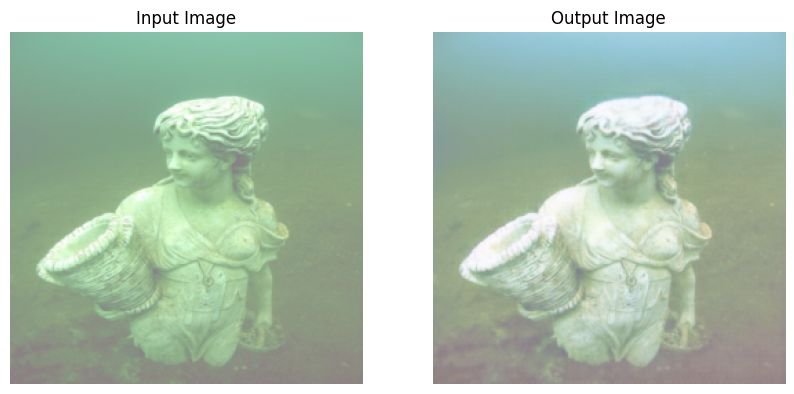

In [64]:
# Path to the input image
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/91_img_.png'  # Change this to your image path

# Load and preprocess the image
input_image = load_image(input_image_path)

# Generate the output image
with torch.no_grad():
    output_image = netG(input_image)

# Display the input and output images
display_images(input_image, output_image)

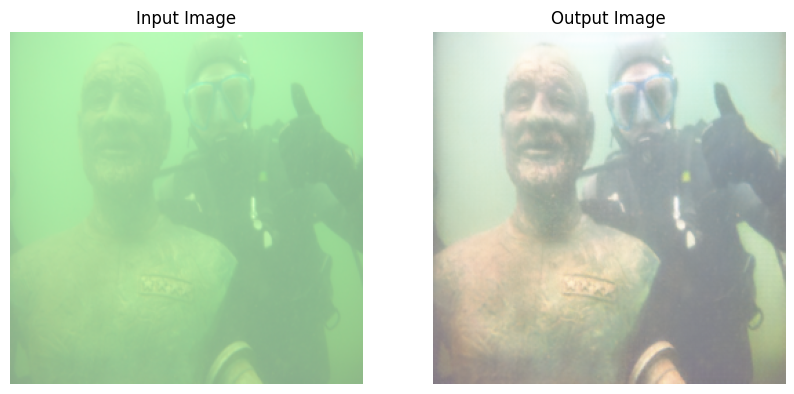

In [65]:
# Path to the input image
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/906_img_.png'  # Change this to your image path

# Load and preprocess the image
input_image = load_image(input_image_path)

# Generate the output image
with torch.no_grad():
    output_image = netG(input_image)

# Display the input and output images
display_images(input_image, output_image)

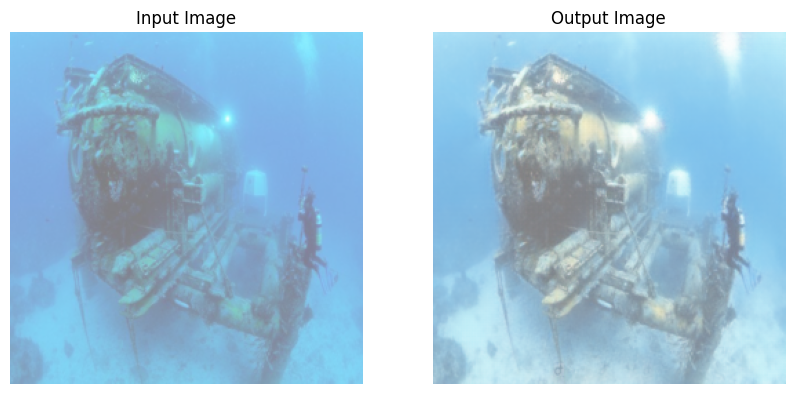

In [66]:
# Path to the input image
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/420_img_.png'  # Change this to your image path

# Load and preprocess the image
input_image = load_image(input_image_path)

# Generate the output image
with torch.no_grad():
    output_image = netG(input_image)

# Display the input and output images
display_images(input_image, output_image)

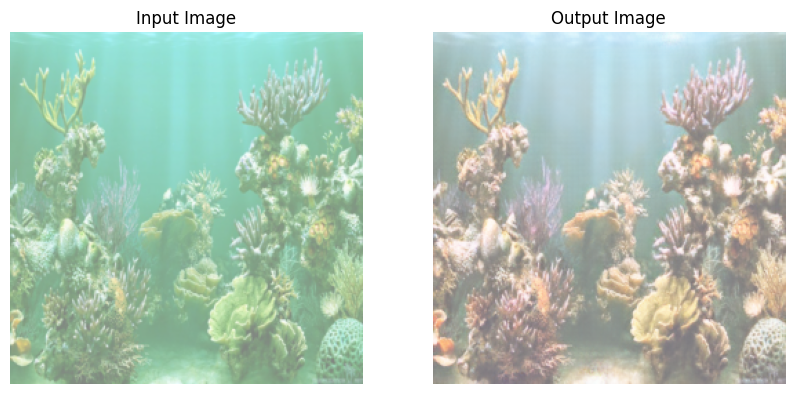

In [67]:
# Path to the input image
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/459_img_.png'  # Change this to your image path

# Load and preprocess the image
input_image = load_image(input_image_path)

# Generate the output image
with torch.no_grad():
    output_image = netG(input_image)

# Display the input and output images
display_images(input_image, output_image)

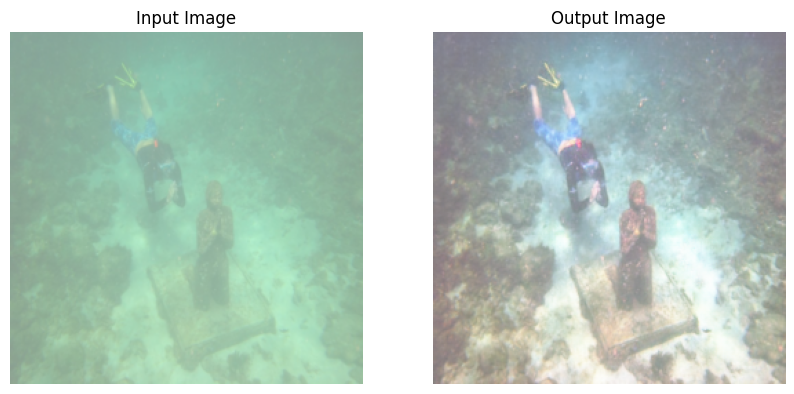

In [68]:
# Path to the input image
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/515_img_.png'  # Change this to your image path

# Load and preprocess the image
input_image = load_image(input_image_path)

# Generate the output image
with torch.no_grad():
    output_image = netG(input_image)

# Display the input and output images
display_images(input_image, output_image)

<ipython-input-69-945d590857a4>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(final_modelG_path, map_location=device))


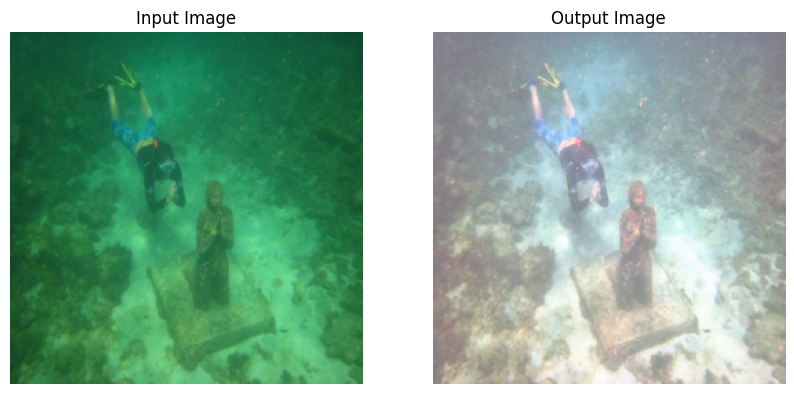

In [69]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
netG = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, padding_type='reflect', use_dropout=True, n_blocks=9).to(device)
netG.load_state_dict(torch.load(final_modelG_path, map_location=device))
netG.eval()  # Set to evaluation mode

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure this matches the input size used during training
    transforms.ToTensor(),
])

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/515_img_.png'  # Change to your image path
input_image = Image.open(input_image_path).convert('RGB')
input_image = transform(input_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Generate output
with torch.no_grad():
    output_image = netG(input_image)

# Convert output image to numpy array
output_image = output_image.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
output_image = (output_image * 0.5 + 0.5) * 255  # Rescale from [-1, 1] to [0, 255]
output_image = np.clip(output_image, 0, 255).astype(np.uint8)  # Clip values to valid range
output_image = np.transpose(output_image, (1, 2, 0))  # Change to HWC format for displaying

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(np.array(input_image.squeeze().cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Output Image")
plt.imshow(output_image)
plt.axis('off')

plt.show()


<ipython-input-70-50d0b133b731>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(final_modelG_path, map_location=device))


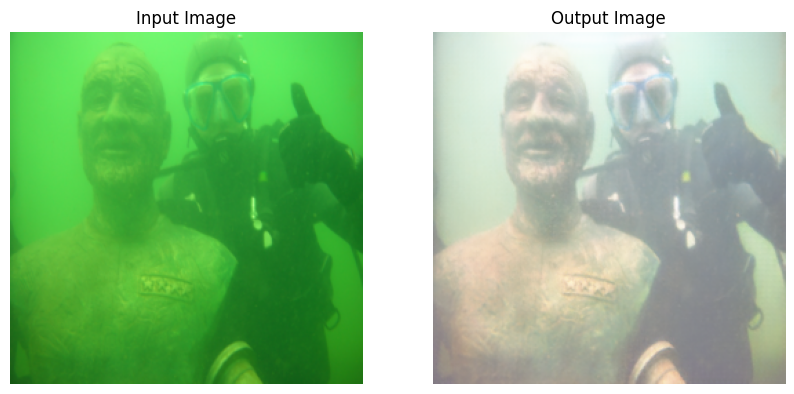

In [70]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
netG = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, padding_type='reflect', use_dropout=True, n_blocks=9).to(device)
netG.load_state_dict(torch.load(final_modelG_path, map_location=device))
netG.eval()  # Set to evaluation mode

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure this matches the input size used during training
    transforms.ToTensor(),
])

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/906_img_.png'  # Change to your image path
input_image = Image.open(input_image_path).convert('RGB')
input_image = transform(input_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Generate output
with torch.no_grad():
    output_image = netG(input_image)

# Convert output image to numpy array
output_image = output_image.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
output_image = (output_image * 0.5 + 0.5) * 255  # Rescale from [-1, 1] to [0, 255]
output_image = np.clip(output_image, 0, 255).astype(np.uint8)  # Clip values to valid range
output_image = np.transpose(output_image, (1, 2, 0))  # Change to HWC format for displaying

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(np.array(input_image.squeeze().cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Output Image")
plt.imshow(output_image)
plt.axis('off')

plt.show()


In [71]:
!pip install torch-fidelity
!pip install torchmetrics

In [72]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.nn.functional import mse_loss

In [73]:
!pip install -U torchmetrics[image]

In [74]:
from torchmetrics.image.fid import FrechetInceptionDistance

In [75]:

import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2
from torchmetrics import MeanSquaredError, PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class for loading raw and reference images
class UIEB_Dataset(Dataset):
    def __init__(self, raw_dir, reference_dir, transform=None):
        self.raw_dir = raw_dir
        self.reference_dir = reference_dir
        self.image_names = sorted(os.listdir(raw_dir))  # Ensure consistent ordering
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        raw_image_path = os.path.join(self.raw_dir, self.image_names[idx])
        reference_image_path = os.path.join(self.reference_dir, self.image_names[idx])

        raw_image = Image.open(raw_image_path).convert('RGB')
        reference_image = Image.open(reference_image_path).convert('RGB')

        if self.transform:
            raw_image = self.transform(raw_image)
            reference_image = self.transform(reference_image)

        return raw_image, reference_image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust this to match your model's input size
    transforms.ToTensor(),
])

# Directory paths
raw_dir = '/content/drive/MyDrive/DIP_Project/raw-890/'
reference_dir = '/content/drive/MyDrive/DIP_Project/reference-890/'

# Create the dataset and dataloader
dataset = UIEB_Dataset(raw_dir, reference_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Load the model (ensure this matches your generator structure)
netG = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, padding_type='reflect', use_dropout=True, n_blocks=9).to(device)
netG.load_state_dict(torch.load(final_modelG_path, map_location=device))
netG.eval()  # Set the model to evaluation mode

# Initialize metrics
mse = MeanSquaredError().to(device)
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)
fid = FrechetInceptionDistance().to(device)

# Function to convert image tensor for FID metric
def convert_to_uint8_for_fid(image_tensor):
    image_tensor = (image_tensor * 255).clamp(0, 255)  # Rescale from [0, 1] to [0, 255]
    return image_tensor.to(torch.uint8)

# Function to calculate UICM (Colorfulness)
def calculate_uicm(image):
    # Convert to LAB color space and calculate colorfulness
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab_image)
    colorfulness = np.sqrt(np.mean(A**2) + np.mean(B**2))
    return colorfulness

# Function to calculate UISM (Sharpness)
def calculate_uism(image):
    # Convert to grayscale and calculate sharpness using Laplacian
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sharpness = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return sharpness

# Function to calculate UIConM (Contrast)
def calculate_uiconm(image):
    # Calculate contrast using standard deviation of pixel intensities
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    contrast = gray_image.std()
    return contrast

# Function to calculate UIQM by combining UICM, UISM, and UIConM
def calculate_uiqm(image):
    uicm = calculate_uicm(image)
    uism = calculate_uism(image)
    uiconm = calculate_uiconm(image)
    # Combine these metrics (weights could be adjusted based on empirical results)
    uiqm = 0.5 * uicm + 0.3 * uism + 0.2 * uiconm
    return uiqm

# Function to process the image tensor and convert it to a numpy array
def tensor_to_numpy(image_tensor):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC
    image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8
    return image

# Iterate through the dataloader
uiqm_scores = []

for batch in dataloader:
    raw_images, reference_images = batch
    raw_images, reference_images = raw_images.to(device), reference_images.to(device)

    # Generate images using the model
    with torch.no_grad():
        generated_images = netG(raw_images)

    # Scale from [-1, 1] to [0, 1] for MSE, PSNR, SSIM
    generated_images_scaled = (generated_images * 0.5 + 0.5)

    # Update metrics (MSE, PSNR, SSIM)
    mse.update(generated_images_scaled, reference_images)
    psnr.update(generated_images_scaled, reference_images)
    ssim.update(generated_images_scaled, reference_images)

    # Convert images for FID metric
    generated_images_uint8 = convert_to_uint8_for_fid(generated_images_scaled)
    reference_images_uint8 = convert_to_uint8_for_fid(reference_images)

    # Update FID metric
    fid.update(generated_images_uint8, real=False)
    fid.update(reference_images_uint8, real=True)

    # Calculate UIQM for each image in the batch
    for img in generated_images_scaled:
        img_numpy = tensor_to_numpy(img)  # Convert to numpy array
        uiqm_value = calculate_uiqm(img_numpy)  # Calculate UIQM
        uiqm_scores.append(uiqm_value)

# Compute final scores
mse_score = mse.compute().item()
psnr_score = psnr.compute().item()
ssim_score = ssim.compute().item()
fid_score = fid.compute().item()
uiqm_score = np.mean(uiqm_scores)  # Average UIQM across the batch

# Print results
print(f"MSE: {mse_score:.4f}")
print(f"PSNR: {psnr_score:.4f}")
print(f"SSIM: {ssim_score:.4f}")
print(f"FID: {fid_score:.4f}")
print(f"UIQM: {uiqm_score:.4f}")


<ipython-input-75-e6ba4b0f7c73>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(final_modelG_path, map_location=device))


MSE: 0.0928
PSNR: 10.3240
SSIM: 0.6564
FID: 20.0756
UIQM: 80.2207
